# Optimizer Example
Jena Climate RNN example showing comparison between Adam and *newer* optimizers.
This is a regression model, using 3-hour data.

Richard Henry, 17-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

# Jena RNN
Here we compare Adam to optimizers which appeared *after* Adam.

Adapted from Keras Documentation.
https://www.tensorflow.org/guide/keras/working_with_rnns

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 2.3 s
Wall time: 2.5 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model function
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(1,
                           activation='linear')
        ]
    )
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    myPre=model.predict(xTrain)
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - loss: 137.4527 - mean_absolute_error: 9.6278 - val_loss: 83.4172 - val_mean_absolute_error: 7.3262
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - loss: 53.8833 - mean_absolute_error: 5.7865 - val_loss: 44.1019 - val_mean_absolute_error: 5.1385
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - loss: 30.8625 - mean_absolute_error: 4.2867 - val_loss: 30.6419 - val_mean_absolute_error: 4.1926
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - loss: 23.8358 - mean_absolute_error: 3.7586 - val_loss: 25.6705 - val_mean_absolute_error: 3.8539
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - loss: 20.5951 - mean_absolute_error: 3.4859 - val_loss: 23.3572 - val_mean_absolute_error: 3.6877
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - loss: 18.9589 - mean_absolute_error: 3.3524 - val_loss: 20.2235 - val_mean_absolute_error: 3.4319
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - loss: 16.5376 - mean_absolute_er

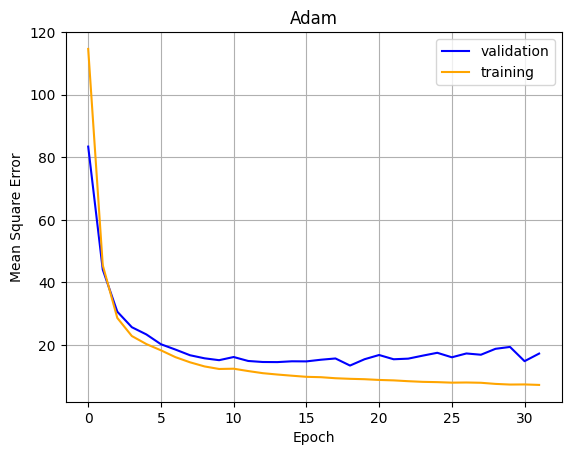

In [13]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

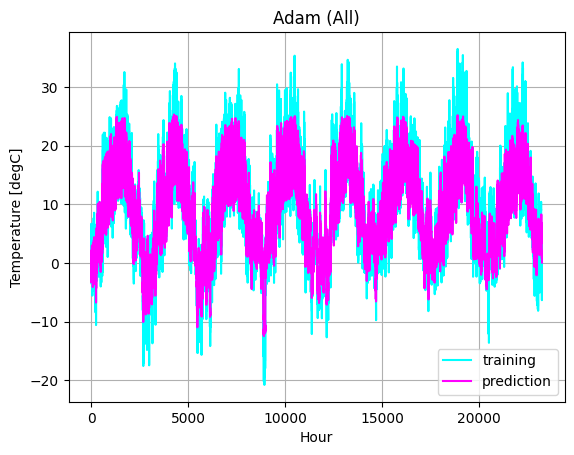

In [14]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (All)')
plt.grid()
plt.show()

In [15]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Year)')
#plt.grid()
#plt.xlim([60588,69348])
#plt.show()

In [16]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Month)')
#plt.grid()
#plt.xlim([68604,69348])
#plt.show()

In [17]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Week)')
#plt.grid()
#plt.xlim([69180,69348])
#plt.show()

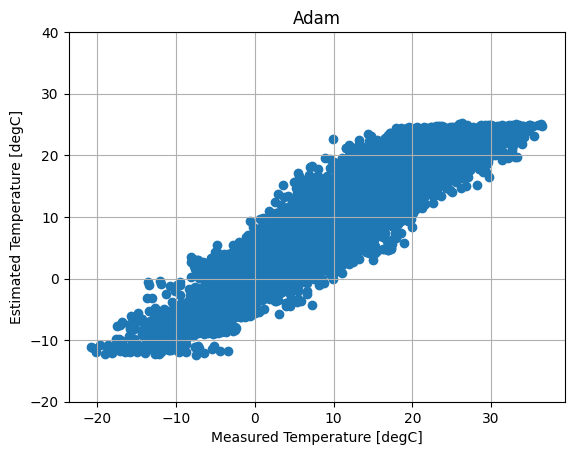

In [18]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.ylim([-20,40])
plt.show()

#### Commentary
Lorem Ipsum
### Second Model, Adam + Weight Decay

In [19]:
%%time
h1,p1=model_build('adamw')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - loss: 137.4341 - mean_absolute_error: 9.6207 - val_loss: 84.9664 - val_mean_absolute_error: 7.5018
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 52.1247 - mean_absolute_error: 5.7006 - val_loss: 39.4934 - val_mean_absolute_error: 4.8231
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 28.7447 - mean_absolute_error: 4.1284 - val_loss: 29.1934 - val_mean_absolute_error: 4.1266
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 23.0869 - mean_absolute_error: 3.7078 - val_loss: 24.6400 - val_mean_absolute_error: 3.7979
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - loss: 20.2822 - mean_absolute_error: 3.4805 - val_loss: 22.2822 - val_mean_absolute_error: 3.6136
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 18.3129 - mean_absolute_error: 3.3049 - val_loss: 20.0066 - val_mean_absolute_error: 3.4102
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 16.4892 - mean_absolute_er

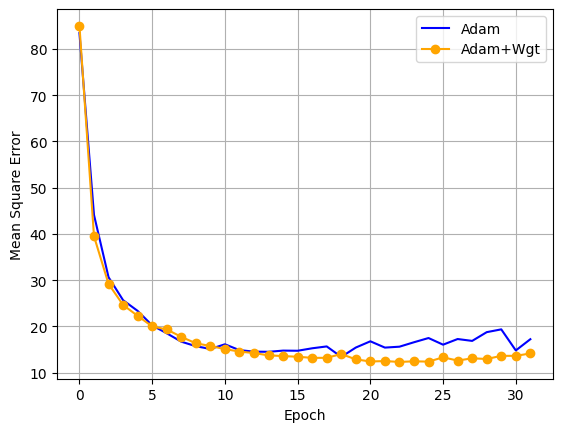

In [20]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h1.history['val_loss'], color='orange',marker='o')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt'])
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Third Model, AdaFactor

In [21]:
%%time
h2,p2=model_build('adafactor')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - loss: 152.9747 - mean_absolute_error: 10.2138 - val_loss: 185.0768 - val_mean_absolute_error: 11.3904
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 145.6658 - mean_absolute_error: 9.9580 - val_loss: 177.1960 - val_mean_absolute_error: 11.1362
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 137.4554 - mean_absolute_error: 9.6581 - val_loss: 167.1657 - val_mean_absolute_error: 10.7890
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 127.6600 - mean_absolute_error: 9.2783 - val_loss: 153.7544 - val_mean_absolute_error: 10.2908
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 115.4992 - mean_absolute_error: 8.7762 - val_loss: 136.0098 - val_mean_absolute_error: 9.5789
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 100.2180 - mean_absolute_error: 8.0975 - val_loss: 115.2692 - val_mean_absolute_error: 8.6684
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 83.6917 - 

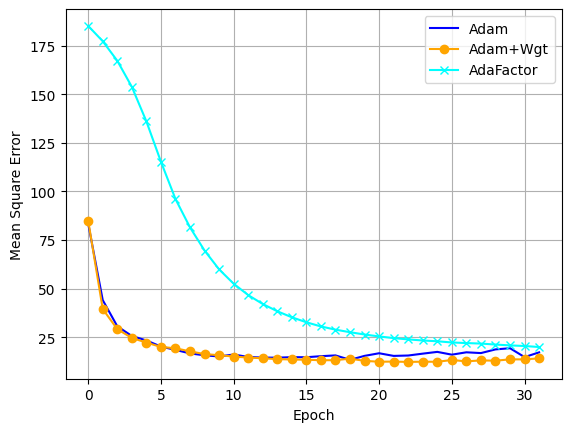

In [22]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','AdaFactor'])
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Fourth Model, LION

In [23]:
%%time
h3,p3=model_build('lion')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - loss: 132.9318 - mean_absolute_error: 9.4739 - val_loss: 77.7672 - val_mean_absolute_error: 7.0217
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 54.2599 - mean_absolute_error: 5.8963 - val_loss: 42.5524 - val_mean_absolute_error: 5.0716
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - loss: 32.8233 - mean_absolute_error: 4.4812 - val_loss: 32.2249 - val_mean_absolute_error: 4.4169
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 27.0428 - mean_absolute_error: 4.0753 - val_loss: 25.6357 - val_mean_absolute_error: 3.9141
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 23.0147 - mean_absolute_error: 3.7781 - val_loss: 22.7296 - val_mean_absolute_error: 3.7289
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 21.0078 - mean_absolute_error: 3.6122 - val_loss: 20.0291 - val_mean_absolute_error: 3.4906
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - loss: 18.0376 - mean_absolute_er

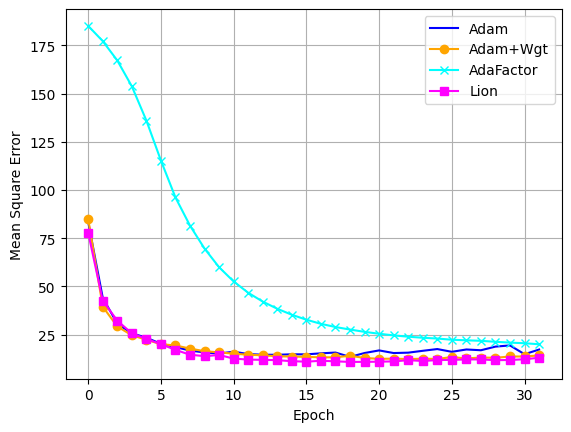

In [24]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','AdaFactor','Lion'])
plt.grid()
plt.show()

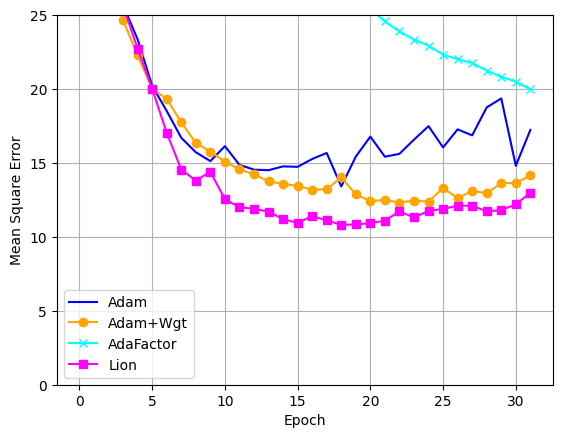

In [25]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','AdaFactor','Lion'])
plt.grid()
plt.ylim([0,25])
plt.show()

5th Model, Adam with Nesterov Momentum

In [26]:
%%time
h4,p4=model_build('nadam')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - loss: 135.2785 - mean_absolute_error: 9.5340 - val_loss: 75.6452 - val_mean_absolute_error: 6.9971
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 46.8696 - mean_absolute_error: 5.3410 - val_loss: 42.1174 - val_mean_absolute_error: 5.0029
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - loss: 30.0866 - mean_absolute_error: 4.2030 - val_loss: 32.4563 - val_mean_absolute_error: 4.3537
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 24.3207 - mean_absolute_error: 3.7842 - val_loss: 26.8974 - val_mean_absolute_error: 3.9372
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - loss: 20.8494 - mean_absolute_error: 3.5125 - val_loss: 23.8069 - val_mean_absolute_error: 3.7114
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 18.5913 - mean_absolute_error: 3.3180 - val_loss: 21.5637 - val_mean_absolute_error: 3.5456
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 16.4990 - mean_absolute_er

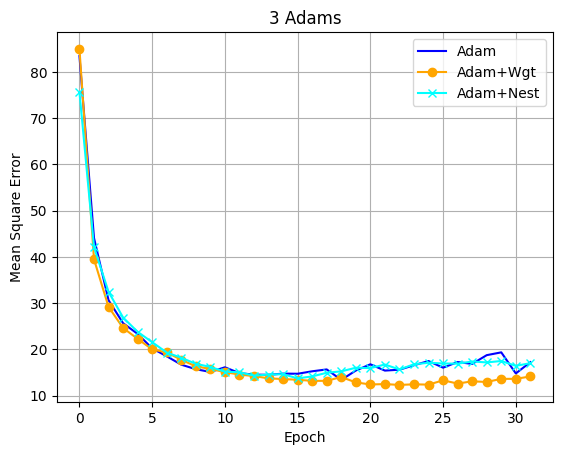

In [27]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h4.history['val_loss'],color='cyan',marker='x')
#plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','LION'])
plt.title('3 Adams')
plt.grid()
plt.show()

6th Model, Follow the Regularized Leader

In [28]:
%%time
h5,p5=model_build('ftrl')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - loss: 152.0169 - mean_absolute_error: 10.1935 - val_loss: 189.2996 - val_mean_absolute_error: 11.5727
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 149.2693 - mean_absolute_error: 10.1064 - val_loss: 187.0669 - val_mean_absolute_error: 11.5208
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 146.6557 - mean_absolute_error: 10.0248 - val_loss: 184.1991 - val_mean_absolute_error: 11.4515
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - loss: 143.1073 - mean_absolute_error: 9.9129 - val_loss: 179.1749 - val_mean_absolute_error: 11.3222
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - loss: 136.3474 - mean_absolute_error: 9.6914 - val_loss: 164.5449 - val_mean_absolute_error: 10.8977
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 115.9878 - mean_absolute_error: 8.9203 - val_loss: 119.5682 - val_mean_absolute_error: 9.1404
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - loss: 83.4926

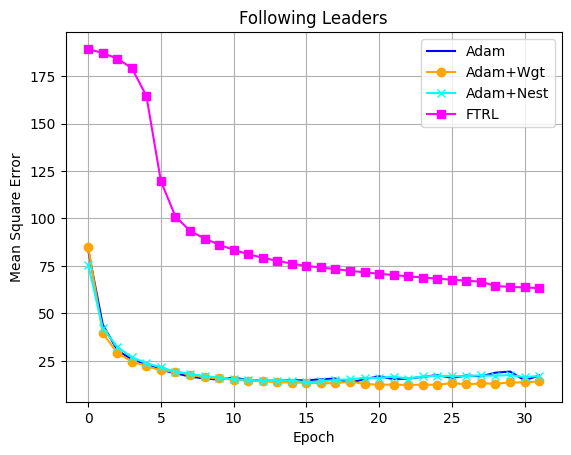

In [30]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h4.history['val_loss'],color='cyan',marker='x')
plt.plot(h5.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','FTRL'])
plt.title('Following Leaders')
plt.grid()
plt.show()

#### Commentary
Lorem Ipsum
# Conclusions
Blah blah blah